# First of all
<br> This is our ([nishipy](https://www.kaggle.com/iamnishipy) & [cpptake](https://www.kaggle.com/takeshikobayashi)) first NLP competition's solution
<br> This kernel was in the silver medal range in the public LB, but in the private LB, the shake down happened and we fall into the bronze medal range
<br> It's frustrating, but we learned a lot, so we'll leave you with the solution
### We'll get a better ranking in next competition!


# Pipe line

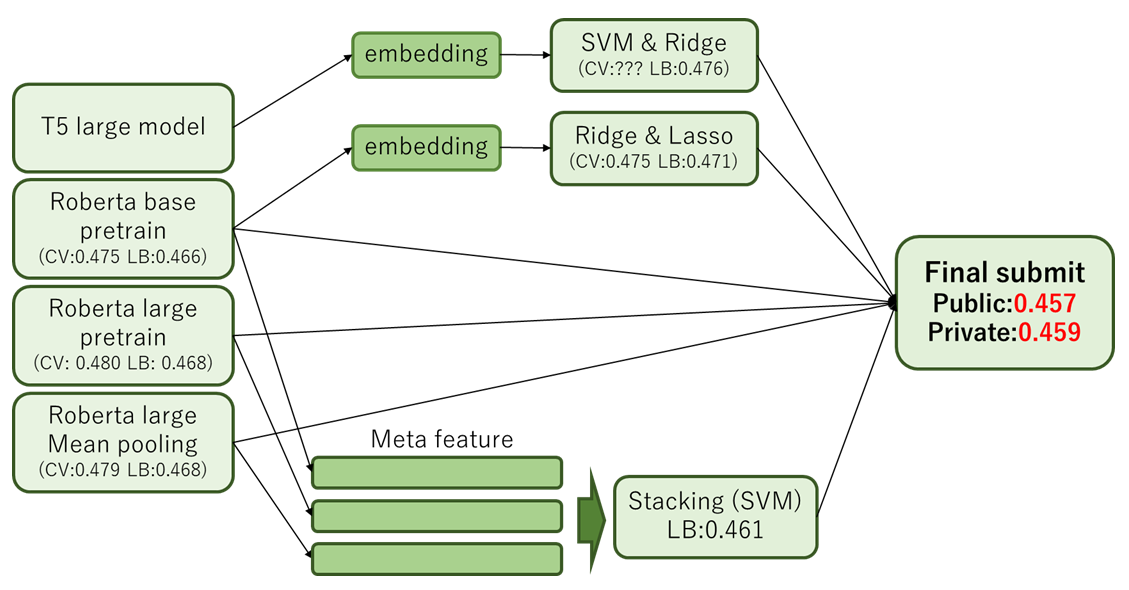


# Our idea
* Using Lasso,Ridge,SVM Blending in the embedding regression
* Using get_liner_schedule_with_warmup at the training phase
* Blending stacking prediction
* Blending pretrain model and unpretrain model
<br> and so on..

# Further improvement points
* Poor diversity of the models
* Poor number of meta feature in the stacking feateure values
* Weak CV in Roberta large


# reference
* https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-infer-3
* https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-itpt
* https://www.kaggle.com/andretugan/pre-trained-roberta-solution-in-pytorch
* https://www.kaggle.com/maunish/clrp-roberta-svm
* https://www.kaggle.com/jcesquiveld/best-transformer-representations
* https://www.kaggle.com/gilfernandes/commonlit-pytorch-t5-large-svm
<br>Thank you [@torch](https://www.kaggle.com/rhtsingh) [@Andrey Tuganov](https://www.kaggle.com/andretugan) [@Maunish dave](https://www.kaggle.com/maunish) [@jcesquivel](https://www.kaggle.com/jcesquiveld) [@gil fernandes](https://www.kaggle.com/gilfernandes) and the comunity for sharing great notebooks!


### If you have any pointers, please comment here!

# Define

In [ ]:
import os
import math
import random
import time
import glob
import re
import gc; gc.enable()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import gc


from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
from torch.utils.data import Dataset, SequentialSampler, DataLoader


import transformers
from transformers import get_cosine_schedule_with_warmup
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging

import gc
gc.enable()


import tensorflow as tf 
from tensorflow.keras.layers import Input,LSTM,Bidirectional,Embedding,Dense, Conv1D, Dropout , MaxPool1D , MaxPooling1D, GlobalAveragePooling2D , GlobalAveragePooling1D , GlobalMaxPooling1D , concatenate , Flatten
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model,load_model,save_model , model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping ,LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from transformers import TFBertModel, BertTokenizerFast , BertTokenizer , RobertaTokenizerFast , TFRobertaModel , RobertaConfig , TFAutoModel , AutoTokenizer



In [ ]:
train_df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission_df = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

# roberta base embedding Lasso & Ridge CV: 0.4753 LB:0.471

In [ ]:
NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 248
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/clrp-roberta-base/clrp_roberta_base/"
TOKENIZER_PATH = "../input/clrp-roberta-base/clrp_roberta_base/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')


num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

target = train_data['target'].to_numpy()
bins = train_data.bins.to_numpy()


def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

config = {
    'batch_size': BATCH_SIZE,
    'max_len': MAX_LEN,
    'nfolds':10,
    'seed':42,
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])


class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.excerpt = df['excerpt'].to_numpy()
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],return_tensors='pt',
                                max_length=config['max_len'],
                                padding='max_length',truncation=True)
        return encode
    
    def __len__(self):
        return len(self.excerpt)
    
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH)
        config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})                       
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
            
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )
        

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids,
                                      attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = roberta_output.hidden_states[-1]

        # The number of cells is MAX_LEN.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is BATCH_SIZE x MAX_LEN x 1
        # last_layer_hidden_states.shape is BATCH_SIZE x MAX_LEN x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is BATCH_SIZE x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        return self.regressor(context_vector)
    

def predict(model, data_loader):
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

def get_embeddings(df,path,plot_losses=True, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
            
    model = Model()
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    
    #tokenizer = AutoTokenizer.from_pretrained('../input/clrp-roberta-base/clrp_roberta_base')
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
    
    ds = CLRPDataset(df, tokenizer)
    dl = DataLoader(ds,
                  batch_size = config["batch_size"],
                  shuffle=False,
                  num_workers = 4,
                  pin_memory=True,
                  drop_last=False
                 )
    
    embeddings = list()
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs.detach().cpu().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)


def get_preds_svm(X,y,X_test,bins=bins,nfolds=10,C=10,kernel='rbf'):
    scores = list()
    preds = np.zeros((X_test.shape[0]))
    preds_ridge = np.zeros((X_test.shape[0]))
    preds_lasso = np.zeros((X_test.shape[0]))
    
    kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
    for k, (train_idx,valid_idx) in enumerate(kfold.split(X,bins)):
        model = SVR(C=5,kernel=kernel,gamma='auto')
        model_ridge = Ridge(alpha=20)
        model_lasso = Lasso(alpha=0.05)

        X_train,y_train = X[train_idx], y[train_idx]
        X_valid,y_valid = X[valid_idx], y[valid_idx]
        
        model.fit(X_train,y_train)
        model_ridge.fit(X_train, y_train)
        model_lasso.fit(X_train,y_train)
        
        prediction = model.predict(X_valid)
        pred_ridge = model_ridge.predict(X_valid)
        pred_lasso = model_lasso.predict(X_valid)
        
        pred_mean = (prediction + pred_ridge + pred_lasso)/3
        
        #score = rmse_score(prediction,y_valid)
        score = rmse_score(y_valid, pred_mean)
        print(f'Fold {k} , rmse score: {score}')
        
        scores.append(score)
        preds += model.predict(X_test)
        preds_ridge += model_ridge.predict(X_test)
        preds_lasso += model_lasso.predict(X_test)
        
    print("mean rmse",np.mean(scores))
    return (np.array(preds)/nfolds + np.array(preds_ridge)/nfolds + np.array(preds_lasso)/nfolds)/3

In [ ]:
train_data = pd.read_csv('../input/commonlit-train-dataset/train_stratiKfold.csv')

train_data.drop(train_data[(train_data.target == 0) & (train_data.standard_error == 0)].index,
              inplace=True)
train_data.reset_index(drop=True, inplace=True)

NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 248
SEED = 1000


# kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)

# for fold, (train_indices, val_indices) in enumerate(kfold.split(train_data)): 
    
#     print("********",fold,"********")
#     train_data.loc[val_indices, 'fold'] = fold
#     # traindf1,val_df1 = train_df.iloc[train_indices],train_df.iloc[val_indices]

train_data.head()

## inference

In [ ]:
from sklearn.linear_model import Lasso

def run():
    preds = []
    scores = []

    svmpreds_list = []
    ridgepreds_list = []
    lassopreds_list = []

    for fold in range(5):

        predssvm = np.zeros((test_df.shape[0]))
        predsridge = np.zeros((test_df.shape[0]))
        predslasso= np.zeros((test_df.shape[0]))

        print('fold  :  ',fold)
        X_train = train_data[train_data["kfold"] != fold]
        y_train = train_data[train_data["kfold"] != fold]['target']
        X_valid = train_data[train_data["kfold"] == fold]
        y_valid = train_data[train_data["kfold"] == fold]['target']

        train_embeddings = get_embeddings(X_train,f'../input/roberta-base-20210730175534-stk/model_{fold + 1}.pth')
        valid_embeddings = get_embeddings(X_valid,f'../input/roberta-base-20210730175534-stk/model_{fold + 1}.pth')
        test_embeddings = get_embeddings(test_data,f'../input/roberta-base-20210730175534-stk/model_{fold + 1}.pth')


#         model = SVR(C=5,kernel='rbf',gamma='auto')
        model_ridge = Ridge(alpha=20)
        model_lasso = Lasso(alpha=0.05)
#         model_xgb = XGBRegressor(booster = 'gblinear',lamdba = 2)#min_child_weight=0.5

#         model.fit(train_embeddings,y_train)
        model_ridge.fit(train_embeddings,y_train)
        model_lasso.fit(train_embeddings,y_train)

#         prediction_svm = model.predict(valid_embeddings)
        prediction_ridge = model_ridge.predict(valid_embeddings)
        prediction_lasso = model_lasso.predict(valid_embeddings)

    #     preds += model.predict(X_test)
    #     preds_ridge += model_ridge.predict(X_test)

#         pred_mean = (prediction_svm + prediction_ridge)/2
        pred_mean = (prediction_ridge + prediction_lasso)/2
        score = rmse_score(y_valid, pred_mean)

        preds.append(pred_mean)

        score = rmse_score(y_valid, pred_mean)
        scores.append(score)
        print(f'fold {fold} score is  : ',score)
        print(scores)

#         predssvm += model.predict(test_embeddings)
        predsridge += model_ridge.predict(test_embeddings)
        predslasso += model_lasso.predict(test_embeddings)

#         svmpreds_list.append(predssvm)
        ridgepreds_list.append(predsridge)
        lassopreds_list.append(predslasso)
        
    print('mean  :  ',np.array(scores).mean())
    
    return (np.array(ridgepreds_list).mean(axis=0) + np.array(lassopreds_list).mean(axis=0))/2
#     return (np.array(svmpreds_list).mean(axis=0) + np.array(ridgepreds_list).mean(axis=0) + np.array(lassopreds_list).mean(axis=0))/3

In [ ]:
roberta_lassoridge_pred = run()
roberta_lassoridge_pred


# pytorch_t5_large_svm LB:0.476
https://www.kaggle.com/gilfernandes/commonlit-pytorch-t5-large-svm

In [ ]:
import yaml, gc
from pathlib import Path
from transformers import T5EncoderModel

class CommonLitModel(nn.Module):
    def __init__(self):
        super(CommonLitModel, self).__init__()
        config = AutoConfig.from_pretrained(cfg.MODEL_PATH)
        config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
        })
        self.transformer_model = T5EncoderModel.from_pretrained(cfg.MODEL_PATH, config=config)
        self.attention = AttentionHead(config.hidden_size, 512, 1)
        self.regressor = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        last_layer_hidden_states = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1) 
        return self.regressor(context_vector), context_vector


BASE_PATH = Path('/kaggle/input/commonlit-t5-large')
DATA_PATH = Path('/kaggle/input/commonlitreadabilityprize/')
assert DATA_PATH.exists()
MODELS_PATH = Path(BASE_PATH/'best_models')
assert MODELS_PATH.exists()

class Config(): 
    NUM_FOLDS = 6
    NUM_EPOCHS = 3
    BATCH_SIZE = 16
    MAX_LEN = 248
    MODEL_PATH = BASE_PATH/'lm'
#     TOKENIZER_PATH = str(MODELS_PATH/'roberta-base-0')
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 1000
    NUM_WORKERS = 2
    MODEL_FOLDER = MODELS_PATH
    model_name = 't5-large'
    svm_kernels = ['rbf']
    svm_c = 5

cfg = Config()

train_df['normalized_target'] = (train_df['target'] - train_df['target'].mean()) / train_df['target'].std()

model_path = MODELS_PATH
assert model_path.exists()

In [ ]:
!ls {MODELS_PATH}

In [ ]:
from transformers import T5EncoderModel

class AttentionHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        
        self.hidden_layer = nn.Linear(in_features, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, num_targets)
        self.out_features = hidden_dim
        
    def forward(self, features):
        att = torch.tanh(self.hidden_layer(features))
        score = self.final_layer(att)
        attention_weights = torch.softmax(score, dim=1)
        return attention_weights



class CommonLitModel(nn.Module):
    def __init__(self):
        super(CommonLitModel, self).__init__()
        config = AutoConfig.from_pretrained(cfg.MODEL_PATH)
        config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
        })
        self.transformer_model = T5EncoderModel.from_pretrained(cfg.MODEL_PATH, config=config)
        self.attention = AttentionHead(config.hidden_size, 512, 1)
        self.regressor = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        last_layer_hidden_states = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1) 
        return self.regressor(context_vector), context_vector
    
def load_model(i):
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(model_path/f'{i + 1}_pytorch_model.bin')))
    inference_model.eval();
    return inference_model

def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)
    
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.MAX_LEN)
    return DataLoader(ds, 
                      batch_size = cfg.BATCH_SIZE,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )


def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            _, context_vector = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
#             cls_embeddings.extend(output['last_hidden_state'][:,0,:].detach().cpu().numpy())
            embedding_out = context_vector.detach().cpu().numpy()
            cls_embeddings.extend(embedding_out)
    return np.array(cls_embeddings)


def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

In [ ]:
!ls {MODELS_PATH}/tokenizer-1

In [ ]:
from transformers import T5Tokenizer

tokenizers = []
for i in range(1, cfg.NUM_FOLDS):
    tokenizer_path = MODELS_PATH/f"tokenizer-{i}"
    print(tokenizer_path)
    assert(Path(tokenizer_path).exists())
    tokenizer = T5Tokenizer.from_pretrained(str(tokenizer_path))
    tokenizers.append(tokenizer)
    
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [ ]:
%%time

train_target = train_df['normalized_target'].values

each_mean_score = []
each_fold_score = []



# for c in C:

final_scores_svm = []
final_scores_ridge = []
final_scores_lasso = []
final_rmse = []

for j, tokenizer in enumerate(tokenizers):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = load_model(j)
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.NUM_FOLDS)
    
    scores = []
    scores_svm = []
    scores_ridge = []
    scores_lasso = []
    
    rmse_scores_svm = []
    rmse_scores_ridge = []
    rmse_scores_lasso = []
    rmse_scores = []
    
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores_svm = []
        kernel_scores_ridge = []
        kernel_scores_lasso = []
        kernel_scores = []
        kernel_rmse_scores = []
        
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model_svm = SVR(C=5, kernel=kernel, gamma='auto')
            model_ridge = Ridge(alpha=20)
            model_lasso = Lasso(alpha=0.05)
#                 model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
        
            model_svm.fit(X_train, y_train)
            model_ridge.fit(X_train, y_train)
#             model_lasso.fit(X_train,y_train)

            pred_svm = model_svm.predict(X_valid)
            pred_ridge = model_ridge.predict(X_valid)
#             pred_lasso = model_lasso.predict(X_valid)

            prediction = (pred_svm + pred_ridge)/2
#             prediction = (pred_svm + pred_ridge + pred_lasso)/3

            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            
            kernel_scores_svm.append(model_svm.predict(X_test))
            kernel_scores_ridge.append(model_ridge.predict(X_test))
#             kernel_scores_lasso.append(model_lasso.predict(X_test))
            
#             score_mean = (np.array(kernel_scores_svm) + np.array(kernel_scores_ridge) + np.array(kernel_scores_lasso))/3
            score_mean = (np.array(kernel_scores_svm) + np.array(kernel_scores_ridge))/2
#             score_mean = (np.array(kernel_scores_ridge) + np.array(kernel_scores_lasso))/2
            kernel_scores.append(score_mean)
            
#         scores.append(calc_mean(kernel_scores))
        scores_svm.append(calc_mean(kernel_scores_svm))
        scores_ridge.append(calc_mean(kernel_scores_ridge))
#         scores_lasso.append(calc_mean(kernel_scores_ridge))
        rmse_scores.append(calc_mean(kernel_rmse_scores))
        
    final_scores_svm.append(calc_mean(scores_svm))
    final_scores_ridge.append(calc_mean(scores_ridge))
#     final_scores_lasso.append(calc_mean(scores_lasso))
    
    final_rmse.append(calc_mean(rmse_scores))
    del transformer_model
    torch.cuda.empty_cache()
    del tokenizer
    gc.collect()
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

each_mean_score.append(np.mean(np.array(final_rmse)))
each_fold_score.append(final_rmse)
    
print('BEST SCORE : ',each_mean_score)
print('FOLD SCORE : ',each_fold_score)

In [ ]:
final_rmse

In [ ]:
# final_scores = (np.array(final_scores_svm)+np.array(final_scores_ridge) + np.array(final_scores_lasso))/3
final_scores = (np.array(final_scores_svm)+np.array(final_scores_ridge))/2
final_scores2 = final_scores * train_df['target'].std() + train_df['target'].mean()

target_mean = train_df['target'].mean()
t5_embedding_pred = calc_mean(final_scores2).flatten()

In [ ]:
t5_embedding_pred

In [ ]:
calc_mean(final_scores2)

In [ ]:
del final_scores,train_target,tokenizers,model_svm,model_ridge,X_train,X_valid,y_valid
gc.collect

# prepare stacking

This kernel is not using roberta mean df

In [ ]:
train_df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')

### nishipyに合わせてtarget and std = 0を消す
train_df.drop(train_df[(train_df.target == 0) & (train_df.standard_error == 0)].index,
              inplace=True)
train_df.reset_index(drop=True, inplace=True)

roberta_df = pd.read_csv('../input/nishipyroberta-dataset/nishipy_roberta_stacking.csv')
robertalarge_df = pd.read_csv('../input/nishipy-robertalarge-dataset/nishipy_robertalarge_stacking.csv')
meanpooling_df = pd.read_csv('../input/meanpoolingdataset/meanpooling_stackingdata.csv')

# robertamean_df = pd.read_csv('../input/meanpoolingrobertabasedataset/meanpooling_roberta_stacking.csv')
# ## 外れ値削除
# robertamean_df = robertamean_df[robertamean_df['id'] != '436ce79fe'].reset_index()


roberta_pred = roberta_df['meanpooling pred']
robertalarge_pred = robertalarge_df['meanpooling pred']
meanpooling_pred = meanpooling_df['meanpooling pred']
# robertamean_pred = robertamean_df['meanpooling roberta pred']

In [ ]:
stacking_df = train_df.drop(['url_legal','license','excerpt','standard_error'],axis = 1)
# stacking_df[['roberta_pred','robertalarge_pred','meanpooling_pred']] = 

stacking_df['roberta_pred'] = roberta_pred
stacking_df['robertalarge_pred'] = robertalarge_pred
stacking_df['meanpooling_pred'] = meanpooling_pred
# stacking_df['robertamean_pred'] = robertamean_pred


In [ ]:
import seaborn as sns

sns.distplot(stacking_df['roberta_pred'], bins=20, color='red')
sns.distplot(stacking_df['robertalarge_pred'], bins=20, color='green')
sns.distplot(stacking_df['meanpooling_pred'], bins=20, color='yellow')
# sns.distplot(stacking_df['robertamean_pred'], bins=20, color='blue')
# sns.displot()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

print('nishipy roberta base RMSE is : ',np.sqrt(mean_squared_error(stacking_df['target'], stacking_df['roberta_pred'])))
print('nishipy roberta large RMSE is : ',np.sqrt(mean_squared_error(stacking_df['target'], stacking_df['robertalarge_pred'])))
print('cpptake roberta large RMSE is : ',np.sqrt(mean_squared_error(stacking_df['target'], stacking_df['meanpooling_pred'])))
# print('cpptake roberta base RMSE is : ',np.sqrt(mean_squared_error(stacking_df['target'], stacking_df['robertamean_pred'])))

# RoBERTa Base CV:0.475 LB:0.466

In [ ]:
NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 248
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/clrp-roberta-base/clrp_roberta_base/"
TOKENIZER_PATH = "../input/clrp-roberta-base/clrp_roberta_base/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.excerpt.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)
        
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH)
        config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})                       
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
            
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )
        

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids,
                                      attention_mask=attention_mask)        

        last_layer_hidden_states = roberta_output.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        return self.regressor(context_vector)
    

def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

In [ ]:
all_predictions = np.zeros((5, len(test_df)))

test_dataset = LitDataset(test_df, inference_only=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         drop_last=False, shuffle=False, num_workers=2)

for index in range(5):
    #CHANGEME
    model_path = f"../input/roberta-base-20210711202147-sche/model_{index + 1}.pth"
    print(f"\nUsing {model_path}")
                        
    model = LitModel()
    model.load_state_dict(torch.load(model_path))    
    model.to(DEVICE)
    
    all_predictions[index] = predict(model, test_loader)
    
    del model
    gc.collect()
    
### nishipy_roberta にNumpy形式で結果を保存
nishipy_roberta = all_predictions.mean(axis=0)
# nishipy_roberta.target = predictions

## release memory

In [ ]:
del all_predictions,test_dataset,test_loader,tokenizer
gc.collect()

# RoBERTa Large CV:0.480 LB:0.468 

In [ ]:
NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 8
MAX_LEN = 248
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"
TOKENIZER_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# nishipy_robertalarge = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [ ]:
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.excerpt.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)
        
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH)
        config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})                       
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
        #https://towardsdatascience.com/attention-based-deep-multiple-instance-learning-1bb3df857e24
        # 768: node fully connected layer
        # 512: node attention layer
        # self.attention = nn.Sequential(            
        #     nn.Linear(768, 512),            
        #     nn.Tanh(),                       
        #     nn.Linear(512, 1),
        #     nn.Softmax(dim=1)
        # )        

        # self.regressor = nn.Sequential(                        
        #     nn.Linear(768, 1)                        
        # )

        #768 -> 1024
        #512 -> 768
        self.attention = nn.Sequential(            
            nn.Linear(1024, 768),            
            nn.Tanh(),                       
            nn.Linear(768, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(1024, 1)                        
        )
        

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids,
                                      attention_mask=attention_mask)        

        last_layer_hidden_states = roberta_output.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        return self.regressor(context_vector)

def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

In [ ]:
all_predictions = np.zeros((5, len(test_df)))

test_dataset = LitDataset(test_df, inference_only=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         drop_last=False, shuffle=False, num_workers=2)

for index in range(5):
    #CHANGEME
    model_path = f"../input/roberta-large-20210720020531-sch/model_{index + 1}.pth"
    print(f"\nUsing {model_path}")
                        
    model = LitModel()
    model.load_state_dict(torch.load(model_path))    
    model.to(DEVICE)
    
    all_predictions[index] = predict(model, test_loader)
    
    del model
    gc.collect()
    
    
## nishipy_robertalargeにNumpy形式で保存
nishipy_robertalarge = all_predictions.mean(axis=0)

# predictions = all_predictions.mean(axis=0)
# nishipy_robertalarge.target = predictions
# # nishipy_robertalarge

In [ ]:
# nishipy_robertalarge

## release memory

In [ ]:

del all_predictions,test_dataset,test_loader,tokenizer
gc.collect()

# Robertalarge meanpooling CV:0.479 LB:0.468

参照：https://www.kaggle.com/jcesquiveld/roberta-large-5-fold-single-model-meanpooling

## import

In [ ]:

SEED = 42

HIDDEN_SIZE = 1024
MAX_LEN = 300

INPUT_DIR = '../input/commonlitreadabilityprize'
# BASELINE_DIR = '../input/commonlit-readability-models/'
BASELINE_DIR = '../input/robertalargemeanpooling'
MODEL_DIR = '../input/roberta-transformers-pytorch/roberta-large'

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_DIR)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8


# robertalarge_meanpool = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
# test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
# test.head()

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(SEED)


class CLRPDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encode = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            max_length=MAX_LEN,
            truncation=True,
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        ) 
        return encode


class MeanPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.linear(mean_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
def predict(df, model):
    
    ds = CLRPDataset(df.excerpt.tolist(), TOKENIZER)
    dl = DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=False
    )
    
    model.to(DEVICE)
    model.eval()
    model.zero_grad()
    
    predictions = []
    for batch in tqdm(dl):
        inputs = {key:val.reshape(val.shape[0], -1).to(DEVICE) for key,val in batch.items()}
        outputs = model(**inputs)
        predictions.extend(outputs.detach().cpu().numpy().ravel())
        
    return predictions

## Inference


In [ ]:

fold_predictions = []
# modelpath = glob.glob(BASELINE_DIR)
modelpath = glob.glob(BASELINE_DIR+"/*")
#余計なデータを削除
modelpath.remove('../input/robertalargemeanpooling/experiment-1.csv')

# for path in glob.glob(BASELINE_DIR + '/*.ckpt'):
for path in modelpath:
    print(path)
    model = MeanPoolingModel(MODEL_DIR)
    model.load_state_dict(torch.load(path))
#     fold = int(re.match(r'.*_f(\d)_.*', path).group(1))
#     print(f'*** fold {fold} ***')
#     y_pred = predict(test, model)
    y_pred = predict(test_df, model)
    fold_predictions.append(y_pred)
    
    # Free memory
    del model
    gc.collect()


robertalarge_meanpool = np.mean(fold_predictions, axis=0)


del fold_predictions,modelpath,y_pred,TOKENIZER
gc.collect()

# Roberta base mean pooling LB:0.476

In [ ]:
# # test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
# # submission_df = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

# config = {
#     'lr': 2e-5,
#     'wd':0.01,
#     'batch_size':16,
#     'valid_step':10,
#     'max_len':256,
#     'epochs':3,
#     'nfolds':5,
#     'seed':42,
#     'model_path':'../input/clrp-roberta-base/clrp_roberta_base',
# }

# # for i in range(config['nfolds']):
# #     os.makedirs(f'model{i}',exist_ok=True)

# def seed_everything(seed=42):
#     random.seed(seed)
#     os.environ['PYTHONASSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

# seed_everything(seed=config['seed'])

In [ ]:
# class CLRPDataset(Dataset):
#     def __init__(self,df,tokenizer):
#         self.excerpt = df['excerpt'].to_numpy()
#         self.tokenizer = tokenizer
    
#     def __getitem__(self,idx):
#         encode = self.tokenizer(self.excerpt[idx],return_tensors='pt',
#                                 max_length=config['max_len'],
#                                 padding='max_length',truncation=True)
#         return encode
    
#     def __len__(self):
#         return len(self.excerpt)
    
    
    
# ### mean pooling 
# class Model(nn.Module):
#     def __init__(self,path):
#         super(Model,self).__init__()
#         self.config = AutoConfig.from_pretrained(path)
#         self.config.update({'output_hidden_states':True,"hidden_dropout_prob": 0.0})
#         self.roberta = AutoModel.from_pretrained(path,config=self.config)  
# #         self.linear = nn.Linear(self.config.hidden_size*4, 1, 1)
#         self.linear = nn.Linear(self.config.hidden_size, 1)
#         self.layer_norm = nn.LayerNorm(self.config.hidden_size)

#     def forward(self,**xb):
#         attention_mask = xb['attention_mask']
#         outputs = self.roberta(**xb)
#         last_hidden_state = outputs[0]
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#         sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#         sum_mask = input_mask_expanded.sum(1)
#         sum_mask = torch.clamp(sum_mask, min=1e-9)
#         mean_embeddings = sum_embeddings / sum_mask
#         norm_mean_embeddings = self.layer_norm(mean_embeddings)
#         logits = self.linear(norm_mean_embeddings)
        
#         preds = logits.squeeze(-1).squeeze(-1)
#         return preds.view(-1).float()
    
    
# def get_prediction(df,path,model_path,device='cuda'):        
#     model = Model(model_path)
#     model.load_state_dict(torch.load(path,map_location=device))
#     model.to(device)
#     model.eval()
    
#     tokenizer = AutoTokenizer.from_pretrained(model_path)
    
#     test_ds = CLRPDataset(df,tokenizer)
#     test_dl = DataLoader(test_ds,
#                         batch_size = config["batch_size"],
#                         shuffle=False,
#                         num_workers = 4,
#                         pin_memory=True)
    
#     predictions = list()
#     for i, (inputs) in tqdm(enumerate(test_dl)):
#         inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
#         outputs = model(**inputs)
#         outputs = outputs.cpu().detach().numpy().ravel().tolist()
#         predictions.extend(outputs)
        
#     torch.cuda.empty_cache()
    
#     del model,tokenizer
#     gc.collect
    
#     return np.array(predictions)

In [ ]:
# all_predictions = np.zeros((5, len(test_df)))

# for fold in range(5):
#     #CHANGEME
#     path = f"../input/robertabasemeanpooling/model{fold}/model{fold}.bin"
#     model_path = '../input/clrp-roberta-base/clrp_roberta_base'
#     print(f"\nUsing  {path} ")
                        
# #     model = Model('../input/clrp-roberta-base/clrp_roberta_base')
# #     model.load_state_dict(torch.load(model_path))
# #     model.to(DEVICE)
    
#     pred = get_prediction(test_df,path,model_path)
#     all_predictions[fold] = pred
#     gc.collect()
    
# robertabase_meanpool = all_predictions.mean(axis=0)

In [ ]:
# robertabase_meanpool

In [ ]:
# del all_predictions,pred

# Stacking 

In [ ]:
submission_df = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')
submission_df = submission_df.drop('target',axis = 1)

submission_df['roberta_pred'] = nishipy_roberta
submission_df['robertalarge_pred'] = nishipy_robertalarge
submission_df['large_meanpooling_pred'] = robertalarge_meanpool
# submission_df['roberta_meanpooling_pred'] = robertabase_meanpool

submission_df

## train

In [ ]:
y_train = stacking_df.target
X_train = stacking_df.drop(['id','target'],axis = 1)
X_test = submission_df.drop('id',axis = 1)
# y_test = submission_df.shape[0]

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression

stacking_model = SVR(kernel='linear', gamma='auto')#'linear'
# stacking_model = LinearRegression()

stacking_model.fit(X_train, y_train)

stacking_pred = stacking_model.predict(X_test)
stacking_pred

# Emsemble

In [ ]:
submission_df = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

predictions = pd.DataFrame()
# predictions = y_test * 0.6 + svm_ridge_preds * 0.2 + roberta_svm_ridge_preds * 0.2

## ver10 t5_large_svm利用
# predictions = y_test * 0.6 + svm_ridge_pred * 0.2 + roberta_svm_ridge_preds * 0.2 

# ## ver12 roberta meanpooling , stacking + blending + t5_large_svm + nishipy roberta svm利用
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool + robertabase_meanpool)/3
# predictions = stacking_pred * 0.3 + blending_pred * 0.3 + svm_ridge_pred * 0.2 + roberta_svm_ridge_preds * 0.2 

## ver14 エラーの原因調査　SVMモデルを削除して　Roberta meanが悪いのか切り分け
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool + robertabase_meanpool)/4
# predictions = stacking_pred * 0.3 + blending_pred * 0.3 + large_svmridge_pred * 0.2 + roberta_svmridge_pred * 0.2

# ## ver17
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool)/3
# predictions = stacking_pred * 0.3 + blending_pred * 0.3 + large_svmridge_pred * 0.2 + roberta_svmridge_pred * 0.2

# ## ver17
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool)/3
# predictions = stacking_pred * 0.3 + blending_pred * 0.3 + ((large_svmridge_pred + roberta_svmridge_pred + t5_embedding_pred)/3) * 0.4

## ver22
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool)/3
# predictions = stacking_pred * 0.2 + blending_pred * 0.25 + roberta_svmridge_pred * 0.2 + t5_embedding_pred * 0.35

## ver22
# blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool + robertabase_meanpool)/4
# predictions = stacking_pred * 0.25 + blending_pred * 0.25 + ((roberta_svmridge_pred + large_svmridge_pred + t5_embedding_pred  + svm_ridge_preds)/4) * 0.5

blending_pred =  (nishipy_roberta + nishipy_robertalarge + robertalarge_meanpool)/3
predictions = stacking_pred * 0.25 + blending_pred * 0.25 + ((roberta_lassoridge_pred + t5_embedding_pred)/2) * 0.5

submission_df.target = predictions
print(submission_df)
submission_df.to_csv("submission.csv", index=False)